In [1]:
import string

In [2]:
class TOKEN:
    def __init__(self, classe, lexema, tipo):
        self.classe = classe
        self.lexema = ''.join(lexema)
        self.tipo = tipo
    
    
    def __str__(self):
        return f'Classe={self.classe}, lexema={self.lexema}, Tipo={self.tipo}'
    
        
class AlphabetError(Exception):
    pass

In [11]:
TABELA_DE_SIMBOLOS = [
    TOKEN('inicio', 'inicio', 'inicio'),
    TOKEN('varinicio', 'varinicio', 'varinicio'),
    TOKEN('varfim', 'varfim', 'varfim'),
    TOKEN('escreva', 'escreva', 'escreva'),
    TOKEN('leia', 'leia', 'leia'),
    TOKEN('se', 'se', 'se'),
    TOKEN('entao', 'entao', 'entao'),
    TOKEN('fimse', 'fimse', 'fimse'),
    TOKEN('fim', 'fim', 'fim'),
    TOKEN('inteiro', 'inteiro', 'inteiro'),
    TOKEN('literal', 'literal', 'literal'),
    TOKEN('real', 'real', 'real')
]


tabela_de_transicao = {
    0: {
        '(': 1,
        ')': 2,
        ';': 3,
        ',': 4,
        'EOF': 5,
        '+': 6,
        '-': 6,
        '*': 6,
        '/': 6,
        'letra': 7,
        '"': 8,
        '{': 10,
        '<': 12,
        '>': 14,
        '=': 15,
        'digito': 16,
        ' ': 0,
        '\n': 0,
        '\t': 0
    },
    1: {},
    2: {},
    3: {},
    4: {},
    5: {},
    6: {},
    7: {
        'letra': 7,
        'digito': 7,
        '_': 7
    },
    8: {
        'curinga': 8,
        '"': 9
    },
    9: {},
    10: {
        'curinga': 10,
        '}': 11
    },
    11: {},
    12: {
        '=': 15,
        '>': 15,
        '-': 13
    },
    13: {},
    14: {
        '=': 15
    },
    15: {},
    16: {
        'digito': 16,
        '.': 17,
        'E': 19,
        'e': 19
    },
    17: {
        'digito': 18
    },
    18: {
        'digito': 18,
        'E': 19,
        'e': 19
    },
    19: {
        'digito': 21,
        '+': 20,
        '-': 20
    },
    20: {
        'digito': 21
    },
    21: {
        'digito': 21
    }
}


estados_finais = {
    0: 'estado inicial',
    1: 'AB_P',
    2: 'FC_P',
    3: 'PT_V',
    4: 'VIR',
    5: 'EOF',
    6: 'OPA',
    7: 'id',
    9: 'Lit',
    11: 'Comentário',
    12: 'OPR',
    13: 'ATR',
    14: 'OPR',
    15: 'OPR',
    16: 'Num',
    18: 'Num',
    21: 'Num'
}


letras = list(string.ascii_letters)
digitos = list(string.digits)
delimitadores = [' ', '\n', '\t'] #Perguntar a prof se fazem parte do alfabeto, pois não estão definidos no projeto
alfabeto = list(letras + digitos + delimitadores + [
    ',', ';', ':', '.', '!', '?', '\\', '*', '+', '-', '/', '(', ')', '{', '}',
    '[', ']', '<', '>', '=', "'", '"', '_'
])

# Definir os tokens ERRO e Ignorar também?

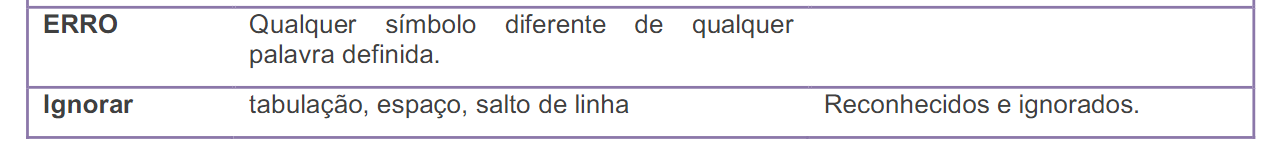

In [ ]:
class AnalisadorLexico:
    def __init__(self, nome_arquivo):

        with open(nome_arquivo, 'r') as fp:
            self.fonte = fp.read()     
        
        self.posicao = 0
        self.linha = 1
        self.coluna = 1
        
        
    def classifica_token(self, estado, lexema):
        if estado == 8 or estado == 10 or estado == 19:
            return TOKEN('ERROR', lexema, None)
        
        elif estado == 7:
            for token in TABELA_DE_SIMBOLOS:
                if token.lexema == ''.join(lexema):
                    return token
                
            novo_id = TOKEN('id', lexema, None)
            TABELA_DE_SIMBOLOS.append(novo_id)
            return novo_id

        elif estado == 16:
            tipo = 'inteiro'
            
        elif estado == 18 or estado == 21:
            tipo = 'real'
            
        elif estado == 9:
            tipo = 'literal'
            
        else:
            tipo = None

        return TOKEN(estados_finais[estado], lexema, tipo)

    
    def chave(self, caractere, estado):
            if (estado == 16 or estado == 18) and (caractere =='e' or caractere == 'E'):
                chave = 'e'
            elif (estado == 8 and caractere != '"') or (estado == 10 and caractere != '}'):
                chave = 'curinga'
            elif caractere in letras:
                chave = 'letra'
            elif caractere in digitos:
                chave = 'digito'
            else:
                chave = caractere

            return chave

   
    def SCANNER(self):
        estado = 0
        lexema = []

        
        while self.posicao <= len(self.fonte): # <= ? Não existe a posição = len(self.fonte), deveria ser apenas <, não?
            try:
                if self.fonte[self.posicao] not in alfabeto:
                    raise AlphabetError
                estado = tabela_de_transicao[estado][self.chave(self.fonte[self.posicao], estado)]

            except AlphabetError:
                if (len(lexema) > 0) and (estado in estados_finais):
                    return self.classifica_token(estado, lexema)
                print(f'ERRO LÉXICO - Caractere inválido na linguagem: {self.fonte[self.posicao]}. Linha {self.linha}, coluna {self.coluna}')
                lexema.append(self.fonte[self.posicao])

            except KeyError:
                if (len(lexema)) > 0 and (estado in estados_finais.keys()):
                    return self.classifica_token(estado, lexema)
                elif estado == 19:
                    print(f'ERRO LÉXICO - Exponenciação incompleta. Linha {self.linha}, coluna {self.coluna}') 
                    return self.classifica_token(estado, lexema)
                
            except IndexError:
                if len(lexema) > 0:
                    return self.classifica_token(estado, lexema)
                else: 
                    break

            else:
                if self.fonte[self.posicao] == '\n':
                    self.linha = self.linha + 1
                    self.coluna = 0
                    
                    if estado == 8:
                        print(f'ERRO LÉXICO - Literal incompleto. Linha {self.linha}, coluna {self.coluna}')
                        return self.classifica_token(estado, lexema)
                    elif estado == 10:
                        print(f'ERRO LÉXICO - Comentário incompleto. Linha {self.linha}, coluna {self.coluna}')
                        return self.classifica_token(estado, lexema)

                if (self.fonte[self.posicao] not in delimitadores) or (estado == 8 or estado == 10):
                    lexema.append(self.fonte[self.posicao])

            finally:
                self.posicao = self.posicao + 1
                self.coluna = self.coluna + 1

        return TOKEN('EOF', 'EOF', None)

In [ ]:
def main():
    al = AnalisadorLexico('..\\Teste\\teste3.txt')
    
    while True:
        
        token = al.SCANNER()
        print(token)
        
        if token.classe == 'EOF':
            break

In [ ]:
main()

Classe=inicio, lexema=inicio, Tipo=inicio
Classe=varinicio, lexema=varinicio, Tipo=varinicio
Classe=literal, lexema=literal, Tipo=literal
Classe=id, lexema=A, Tipo=None
Classe=inteiro, lexema=inteiro, Tipo=inteiro
Classe=id, lexema=B, Tipo=None
Classe=id, lexema=D, Tipo=None
Classe=id, lexema=E, Tipo=None
Classe=real, lexema=real, Tipo=real
Classe=id, lexema=C, Tipo=None
Classe=PT_V, lexema=;, Tipo=None
Classe=varfim, lexema=varfim, Tipo=varfim
Classe=escreva, lexema=escreva, Tipo=escreva
Classe=Lit, lexema="Digite B:", Tipo=literal
Classe=leia, lexema=leia, Tipo=leia
Classe=id, lexema=B, Tipo=None
Classe=escreva, lexema=escreva, Tipo=escreva
Classe=Lit, lexema="Digite A:", Tipo=literal
Classe=leia, lexema=leia, Tipo=leia
Classe=id, lexema=A, Tipo=None
Classe=se, lexema=se, Tipo=se
Classe=id, lexema=B, Tipo=None
Classe=Num, lexema=2, Tipo=inteiro
Classe=entao, lexema=entao, Tipo=entao
Classe=se, lexema=se, Tipo=se
Classe=id, lexema=B, Tipo=None
Classe=OPR, lexema==, Tipo=None
Classe=FC

In [45]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   ../Analisador-Lexico/ClasseAnalisadorLexico.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [46]:
!git add .

In [47]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   ../Analisador-Lexico/ClasseAnalisadorLexico.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
!git add ../Analisador-Lexico/